<a href="https://colab.research.google.com/github/MajPaji/AI-corr-eye/blob/main/corr_eye_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project G19-0052 Computer vision on different corrosion mode recognition


It is difficult even for trained engineer eyes to recognize between different types of failure, but it is crucial to recognize these modes of failure to develop new products or modify the production steps to avoid these types of corrosion for current products. It needs to do many additional laboratory experiments like metallography, chemical analysis, and SEM to understand and recognize between different types of failure. 

In the R&D department, we have a long history of these kinds of measurements and failure analysis. This project aims to use deep learning and computer vision using TensorFlow to recognize between these failures. This could make a great reference for classification between different corrosion modes. This would avoid a lot of time and resources to recognize and understand failures. Data collected from 2016 to 2020 in the case studies that have recognized these failures. 

## Project objectives

There are two common failures in aluminum alloy pitting and IGC. The first aim is to recognize these modes of failure and later add more complicated types to recognize like Ti-effect, crevice, de-alloying, etc.

In [2]:
# importing the data set IGC and pitting (data_set_igc_pit.zip)
# data set file in content>gdrive>MyDrive>data_set_igc_pit.zip
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
# unzip the file to coolab tmp folder

import os, shutil
import zipfile

zip_file_dir = '/content/gdrive/MyDrive/igc-pit.zip'
zip_file = zipfile.ZipFile(zip_file_dir, 'r')
zip_file.extractall('/tmp/igc-pit')
zip_file.close()

## Data set for IGC and Pit failure cases

There were 368 images collected for IGC failure of the products and 737 for pitting failure of the products. In total there were 1105 images in this data set.

In [5]:
igc_dir = os.path.join('/tmp/igc-pit/igc-pit/igc')
pit_dir = os.path.join('/tmp/igc-pit/igc-pit/pit')

print(f'number of IGC failure images: {len(os.listdir(igc_dir))}')
print(f'number of Pit failure images: {len(os.listdir(pit_dir))}')

number of IGC failure images: 368
number of Pit failure images: 737


In [13]:
# divid the train file to train test split
# get 10% of the images for tesing and the rest for training

import splitfolders

splitfolders.ratio("/tmp/igc-pit/igc-pit", output="/tmp/igc-pit/output", seed=1337, ratio=(.8, .1, .1))

Copying files: 1105 files [00:00, 2032.29 files/s]


In [17]:
# move test files to training folders

igc_source_dir = os.path.join('/tmp/igc-pit/output/test/igc/')
igc_target_dir = os.path.join('/tmp/igc-pit/output/train/igc/')

file_names = os.listdir(igc_source_dir)

for f in file_names:
  shutil.move(os.path.join(igc_source_dir, f), igc_target_dir)


pit_source_dir = os.path.join('/tmp/igc-pit/output/test/pit/')
pit_target_dir = os.path.join('/tmp/igc-pit/output/train/pit/')

file_names = os.listdir(pit_source_dir)

for f in file_names:
  shutil.move(os.path.join(pit_source_dir, f), pit_target_dir)

## Data set training and validation

The data set is organized to have one set for training and the other for validation. 90% of the data will be used for training and 10% for validation.

There are:

* IGC cases for train is 332 and validation set number is 36
* Pit cases for train is 664 and validation set number is 73




In [23]:
igc_train_dir = os.path.join('/tmp/igc-pit/output/train/igc')
pit_train_dir = os.path.join('/tmp/igc-pit/output/train/pit')

igc_val_dir = os.path.join('/tmp/igc-pit/output/val/igc')
pit_val_dir = os.path.join('/tmp/igc-pit/output/val/pit')

print(f'number of IGC cases for train is {len(os.listdir(igc_train_dir))} and validation set number is {len(os.listdir(igc_val_dir))}')
print(f'number of Pit cases for train is {len(os.listdir(pit_train_dir))} and validation set number is {len(os.listdir(pit_val_dir))}')

number of IGC cases for train is 332 and validation set number is 36
number of Pit cases for train is 664 and validation set number is 73


In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Looking at the IGC case

In the figure below the first row show, two examples IGC cases that will be used for training the model and the next row shows two examples of the cases that will be used for validation of the model

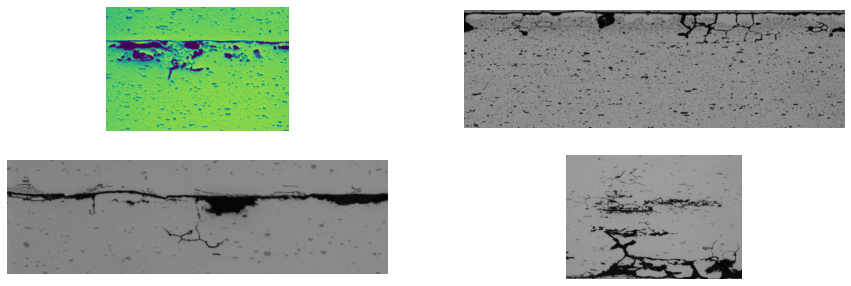

In [47]:
fig = plt.gcf()
fig.set_size_inches (15, 5)

igc_train_img = [os.path.join('/tmp/igc-pit/output/train/igc', fn) for fn in os.listdir('/tmp/igc-pit/output/train/igc')[10:12]]
igc_val_img = [os.path.join('/tmp/igc-pit/output/val/igc', fn) for fn in os.listdir('/tmp/igc-pit/output/val/igc')[10:12]]

for i, img_path in enumerate(igc_train_img + igc_val_img, 1):

  spl = plt.subplot(2, 2, i )
  spl.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Looking at the Pitting case

In the figure below the first row show, two examples pitting cases that will be used for training the model and the next row shows two examples of the cases that will be used for validation of the model

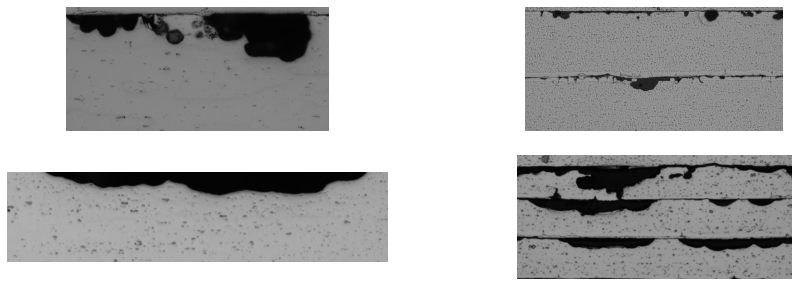

In [49]:
fig = plt.gcf()
fig.set_size_inches (15, 5)

pit_train_img = [os.path.join('/tmp/igc-pit/output/train/pit', fn) for fn in os.listdir('/tmp/igc-pit/output/train/pit')[10:12]]
pit_val_img = [os.path.join('/tmp/igc-pit/output/val/pit', fn) for fn in os.listdir('/tmp/igc-pit/output/val/pit')[10:12]]

for i, img_path in enumerate(pit_train_img + pit_val_img, 1):

  spl = plt.subplot(2, 2, i )
  spl.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Building a model 

We have used Tensorflow for deep learning and because this is just a binary classification problem, we end up the neutral network with a sigmoid activation which leads to an output for the network to be a single scalar between 0 to 1 which is the probability of the current image class.
The first layer of the NN gets the image in 300 x 300 pixels and using the convolution and pooling we extract the image in four-set of double layers. the summary method shows how the model abstracts the image.

In [2]:
import tensorflow as tf

In [52]:
model_igc_pit = tf.keras.models.Sequential([
    # first double layer of convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second double layer of convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third double layer of convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth double layer of convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # flatten the results for NN
    tf.keras.layers.Flatten(),
    # number if hidden neurons : 512
    tf.keras.layers.Dense(512, activation='relu'),
    # only one neuron '0' for IGC and '1' for Pit
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## Model (model_igc_pit) summary

Summary of the model shows that each image data is converted from 16384 for each image which would reduce the number of the iteration. This image abstraction might cause some feature recognition for IGC corrosion form because IGC show in the more limited area in the image which could cause a problem for the model fitting this would be investigated in the next model with less convulsion layers

In [53]:
model_igc_pit.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [5]:
# using RMSprop for the optimizer and binary_crossentropy for loss function
from tensorflow.keras.optimizers import RMSprop

model_igc_pit.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

NameError: ignored

In [3]:
# bulding the train and validation data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        '/tmp/igc-pit/output/train/',  
        target_size=(300, 300),
        class_mode='binary')

val_generator = val_datagen.flow_from_directory(
        '/tmp/igc-pit/output/val/',  
        target_size=(300, 300),  
        class_mode='binary')

Found 996 images belonging to 2 classes.
Found 109 images belonging to 2 classes.


In [63]:
# fitting the model
history = model_igc_pit.fit(
      train_generator,
      epochs=15,
      verbose=1,
      validation_data = val_generator,
      )

Epoch 1/15
32/32 [==============================] - 15s 456ms/step - loss: 0.6125 - accuracy: 0.6777 - val_loss: 0.4774 - val_accuracy: 0.7523
Epoch 2/15
32/32 [==============================] - 14s 448ms/step - loss: 0.5666 - accuracy: 0.7319 - val_loss: 0.5247 - val_accuracy: 0.8257
Epoch 3/15
32/32 [==============================] - 14s 448ms/step - loss: 0.3923 - accuracy: 0.8273 - val_loss: 0.2409 - val_accuracy: 0.9358
Epoch 4/15
32/32 [==============================] - 14s 447ms/step - loss: 0.3243 - accuracy: 0.8584 - val_loss: 0.8718 - val_accuracy: 0.5505
Epoch 5/15
32/32 [==============================] - 14s 447ms/step - loss: 0.3009 - accuracy: 0.8795 - val_loss: 0.2052 - val_accuracy: 0.9358
Epoch 6/15
32/32 [==============================] - 14s 448ms/step - loss: 0.2007 - accuracy: 0.9277 - val_loss: 0.5079 - val_accuracy: 0.8349
Epoch 7/15
32/32 [==============================] - 15s 454ms/step - loss: 0.1467 - accuracy: 0.9408 - val_loss: 0.5580 - val_accuracy: 0.8716

In [65]:
# saving the model 
tf.keras.models.save_model(
    model_igc_pit,
    os.path.join('/content/gdrive/MyDrive/models/model_igc_pit/'),
    overwrite=True,
    include_optimizer=True,
    save_format="tf",
    signatures=None
)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/model_igc_pit/assets


In [76]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Comment on the model (model_igc_pit)

In the graphs below, one can see the accuracy and loss over the number of epochs. The accuracy for the training and validation set of increased but it seems this can be improved with more iteration and the increasing number of epochs. So, the model will be trained with number of epoch 50.

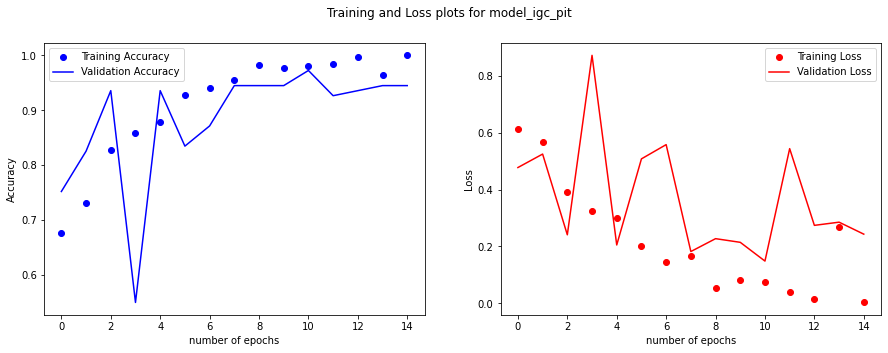

In [108]:
train_acc_model_igc_pit = history.history['accuracy'] # training accuracy score of the model
val_acc_model_igc_pit = history.history['val_accuracy'] # validation accuracy score of the model

train_loss_model_igc_pit = history.history['loss'] # training loss score of the model
val_loss_model_igc_pit = history.history['val_loss'] # validation loss score of the model


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training and Loss plots for model_igc_pit')
fig = plt.gcf()
fig.set_size_inches (15, 5)

epochs = range(len(train_acc_model_igc_pit))

ax1.plot(epochs, train_acc_model_igc_pit, 'bo', label = 'Training Accuracy')
ax1.plot(epochs, val_acc_model_igc_pit, 'b', label = 'Validation Accuracy')
ax1.set(xlabel='number of epochs', ylabel='Accuracy')
ax1.legend()

ax2.plot(epochs, train_loss_model_igc_pit, 'ro', label = 'Training Loss')
ax2.plot(epochs, val_loss_model_igc_pit, 'r', label = 'Validation Loss')
ax2.set(xlabel='number of epochs', ylabel='Loss')
ax2.legend()

plt.show()

In [110]:
# make a model for 50 epochs

model_igc_pit_50 = tf.keras.models.Sequential([
    # first double layer of convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second double layer of convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third double layer of convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth double layer of convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # flatten the results for NN
    tf.keras.layers.Flatten(),
    # number if hidden neurons : 512
    tf.keras.layers.Dense(512, activation='relu'),
    # only one neuron '0' for IGC and '1' for Pit
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_igc_pit_50.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# fitting the model
history_50 = model_igc_pit_50.fit(
      train_generator,
      epochs=50,
      verbose=1,
      validation_data = val_generator,
      )

Epoch 1/50
32/32 [==============================] - 15s 462ms/step - loss: 0.8507 - accuracy: 0.6235 - val_loss: 0.6409 - val_accuracy: 0.7523
Epoch 2/50
32/32 [==============================] - 14s 437ms/step - loss: 0.5570 - accuracy: 0.7008 - val_loss: 0.6462 - val_accuracy: 0.7064
Epoch 3/50
32/32 [==============================] - 14s 441ms/step - loss: 0.4303 - accuracy: 0.7982 - val_loss: 0.4867 - val_accuracy: 0.7156
Epoch 4/50
32/32 [==============================] - 14s 437ms/step - loss: 0.3626 - accuracy: 0.8444 - val_loss: 0.2096 - val_accuracy: 0.9450
Epoch 5/50
32/32 [==============================] - 14s 442ms/step - loss: 0.2849 - accuracy: 0.8886 - val_loss: 0.2236 - val_accuracy: 0.9174
Epoch 6/50
32/32 [==============================] - 14s 440ms/step - loss: 0.1965 - accuracy: 0.9207 - val_loss: 0.1490 - val_accuracy: 0.9541
Epoch 7/50
32/32 [==============================] - 14s 445ms/step - loss: 0.1378 - accuracy: 0.9488 - val_loss: 0.1944 - val_accuracy: 0.9450

In [111]:
# saving the model 
tf.keras.models.save_model(
    model_igc_pit_50,
    os.path.join('/content/gdrive/MyDrive/models/model_igc_pit_50/'),
    overwrite=True,
    include_optimizer=True,
    save_format="tf",
    signatures=None
)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/model_igc_pit_50/assets


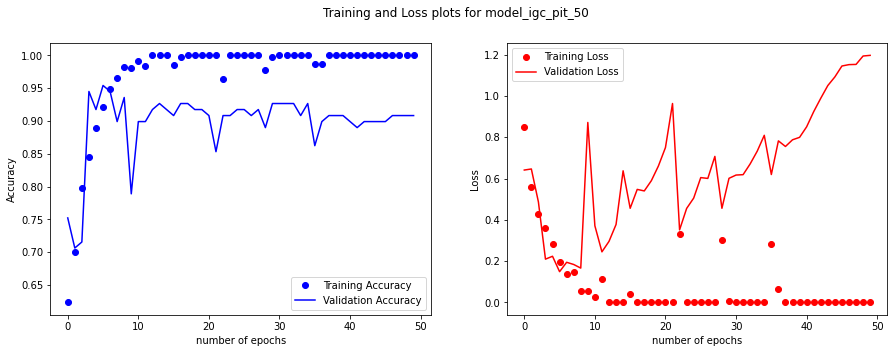

In [113]:
train_acc_model_igc_pit = history_50.history['accuracy'] # training accuracy score of the model
val_acc_model_igc_pit = history_50.history['val_accuracy'] # validation accuracy score of the model

train_loss_model_igc_pit = history_50.history['loss'] # training loss score of the model
val_loss_model_igc_pit = history_50.history['val_loss'] # validation loss score of the model


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training and Loss plots for model_igc_pit_50')
fig = plt.gcf()
fig.set_size_inches (15, 5)

epochs = range(len(train_acc_model_igc_pit))

ax1.plot(epochs, train_acc_model_igc_pit, 'bo', label = 'Training Accuracy')
ax1.plot(epochs, val_acc_model_igc_pit, 'b', label = 'Validation Accuracy')
ax1.set(xlabel='number of epochs', ylabel='Accuracy')
ax1.legend()

ax2.plot(epochs, train_loss_model_igc_pit, 'ro', label = 'Training Loss')
ax2.plot(epochs, val_loss_model_igc_pit, 'r', label = 'Validation Loss')
ax2.set(xlabel='number of epochs', ylabel='Loss')
ax2.legend()

plt.show()

## Comment on the model (model_igc_pit_50)

The increasing number of epoch did not improve the model performance to a very high extend. After 20 epochs the training accuracy reached value one which is an indication of overfitting, also the validation accuracy reached almost 90% and got plateau. It is interesting which loss got plateau after 20 epoch to almost zero but the loss accuracy increased with the number of epochs.  
In the next step, just two double convolution layers are going to be used. This might be increase the model accuracy.

The following changes made to the model: 

* Increased number of filters of the last layer NN in the model
* Decreased the input size of the images to 150 x 150
* Added a callback function to stop the training at the training accuracy of more than 97% and validation accuracy more than 95 %

In [29]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.95 and logs.get('accuracy') > 0.97):
            print('\n Reached more than 95% validation accuracy and 97% training accuracy, canceled the training \n')
            self.model.stop_training = True
            
callbacks = myCallback()

In [30]:
# reduce number of the convolution layers and make a model for 25 epochs

train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        '/tmp/igc-pit/output/train/',  
        target_size=(150, 150),
        class_mode='binary')

val_generator = val_datagen.flow_from_directory(
        '/tmp/igc-pit/output/val/',  
        target_size=(150, 150),  
        class_mode='binary')


model_igc_pit_layer = tf.keras.models.Sequential([
    # first double layer of convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second double layer of convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third double layer of convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth double layer of convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
 
    
    # flatten the results for NN
    tf.keras.layers.Flatten(),
    # number if hidden neurons : 512
    tf.keras.layers.Dense(512, activation='relu'),
    # only one neuron '0' for IGC and '1' for Pit
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_igc_pit_layer.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# fitting the model
history_50 = model_igc_pit_layer.fit(
      train_generator,
      epochs=25,
      verbose=1,
      validation_data = val_generator,
      callbacks = [callbacks],
      )

Found 996 images belonging to 2 classes.
Found 109 images belonging to 2 classes.
Epoch 1/25
32/32 [==============================] - 14s 412ms/step - loss: 0.9016 - accuracy: 0.6396 - val_loss: 0.5928 - val_accuracy: 0.6697
Epoch 2/25
32/32 [==============================] - 13s 397ms/step - loss: 0.6209 - accuracy: 0.6245 - val_loss: 0.4527 - val_accuracy: 0.8624
Epoch 3/25
32/32 [==============================] - 13s 399ms/step - loss: 0.5282 - accuracy: 0.7249 - val_loss: 0.4849 - val_accuracy: 0.7523
Epoch 4/25
32/32 [==============================] - 13s 401ms/step - loss: 0.4308 - accuracy: 0.8072 - val_loss: 0.3061 - val_accuracy: 0.9450
Epoch 5/25
32/32 [==============================] - 13s 399ms/step - loss: 0.3573 - accuracy: 0.8645 - val_loss: 0.2432 - val_accuracy: 0.9083
Epoch 6/25
32/32 [==============================] - 13s 401ms/step - loss: 0.3129 - accuracy: 0.8685 - val_loss: 0.1747 - val_accuracy: 0.9450
Epoch 7/25
32/32 [==============================] - 13s 400m

In [33]:
# saving the model 
tf.keras.models.save_model(
    model_igc_pit_layer,
    os.path.join('/content/gdrive/MyDrive/models/model_igc_pit_layer/'),
    overwrite=True,
    include_optimizer=True,
    save_format="tf",
    signatures=None
)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/model_igc_pit_layer/assets


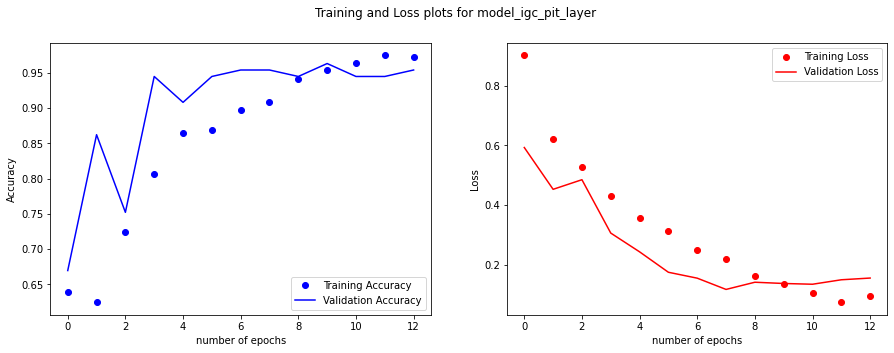

In [36]:
train_acc_model_igc_pit = history_50.history['accuracy'] # training accuracy score of the model
val_acc_model_igc_pit = history_50.history['val_accuracy'] # validation accuracy score of the model

train_loss_model_igc_pit = history_50.history['loss'] # training loss score of the model
val_loss_model_igc_pit = history_50.history['val_loss'] # validation loss score of the model


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training and Loss plots for model_igc_pit_layer')
fig = plt.gcf()
fig.set_size_inches (15, 5)

epochs = range(len(train_acc_model_igc_pit))

ax1.plot(epochs, train_acc_model_igc_pit, 'bo', label = 'Training Accuracy')
ax1.plot(epochs, val_acc_model_igc_pit, 'b', label = 'Validation Accuracy')
ax1.set(xlabel='number of epochs', ylabel='Accuracy')
ax1.legend()

ax2.plot(epochs, train_loss_model_igc_pit, 'ro', label = 'Training Loss')
ax2.plot(epochs, val_loss_model_igc_pit, 'r', label = 'Validation Loss')
ax2.set(xlabel='number of epochs', ylabel='Loss')
ax2.legend()

plt.show()

## Testing the model

The model is tested in real cases. Many articles are showing the failure mode of aluminum alloys. The images were extracted and tested with the model. These are the examples:

### IGC case: 

* Effects of aging treatment and peripheral coarse grain on the exfoliation corrosion behaviour of 2024 aluminium alloy using SR-CT [link to the article](https://www.sciencedirect.com/science/article/pii/S2238785419313961)

> **Figure-8** from this article demonstrating an IGC form image.

### Piting case:

* Heat treatment of aluminium alloys produced by laser powder bed fusion: A review [link to the article](https://www.sciencedirect.com/science/article/pii/S0264127521002045)



> **Figure-21** from this article demonstrating an pitting form image.



In [4]:
import os
import tensorflow as tf

corrosion_eye_model = tf.keras.models.load_model(
    os.path.join('/content/gdrive/MyDrive/models/model_igc_pit_layer'),
    custom_objects=None,
    compile=True
)

Saving Figure-8.PNG to Figure-8.PNG
Saving Figure-21.PNG to Figure-21.PNG


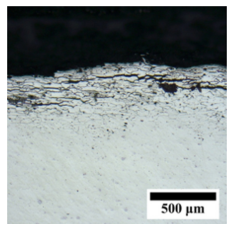

Figure-8.PNG is recognized as a IGC failure



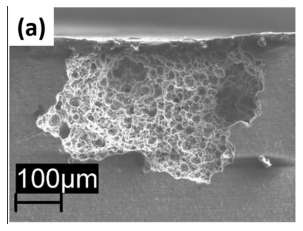

Figure-21.PNG is recognized as a pitting failure



In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  
  # show the original image
  plt.imshow(mpimg.imread(path))
  plt.axis('Off')
  plt.show()
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = corrosion_eye_model.predict(images, batch_size=10)
  
  if classes[0]>0.5:
    print(fn + " is recognized as a pitting failure")
  else:
    print(fn + " is recognized as a IGC failure")
  print('')